# Importações

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.figsize'] = (15, 10)

# Funções uteis

In [2]:
def plot_res_e_pred(valor_pred, valor_real, titulo_grafico):
    df_pred = pd.DataFrame({"predicao":valor_pred, "valor_real":valor_real})
    df_pred["residuos"] = df_pred["valor_real"] - df_pred["predicao"]
    df_pred.plot(x = "predicao", y = "residuos", kind = "scatter")
    plt.title(titulo_grafico)
    return df_pred

def calcular_rmse_cv(model,  x_geral, y_geral, cv):
    rmse = np.sqrt(-cross_val_score(model, x_geral, y_geral, scoring="neg_mean_squared_error", cv=cv, n_jobs = -1))
    print("Valor do RMSE: {0} ".format(rmse))
    return rmse

def calcular_rmse(y, y_pred):
  return mean_squared_error(y, y_pred, squared = False)

def plot_validacao(values, alphas, title):
    data = pd.Series(values, index=alphas)
    data.plot(title = "Validação")
    plt.xlabel("alpha")
    plt.ylabel(title)

def print_shape(df = [], df2 = []):
  if len(df) > 0:
    print(f"Shape df 1: {df.shape}")
  if len(df2) > 0:
    print(f"Shape df 2: {df2.shape}")

def get_df_plot(valor_pred, valor_real):
    df_pred = pd.DataFrame({"predicao":valor_pred, "valor_real":valor_real})
    df_pred["residuos"] = df_pred["valor_real"] - df_pred["predicao"]
    return df_pred

# Dataset

O nome das colunas nos dois datasets estão diferentes. Resolvi padronizar e deixar os dois iguais.

In [3]:

col_names=['ano', 'sq_candidato', 'nome', 'uf', 'partido',
       'qtd_doacoes', 'qtd_doadores', 'total_receita', 'media_receita',
       'recursos de outros candidatos/comitês', 'recursos de pessoas físicas',
       'recursos de pessoas jurídicas', 'recursos próprios', 'qtd_despesas',
       'qtd_fornecedores', 'total_despesa', 'media_despesa', 'cargo',
       'sexo', 'grau_instrucao', 'estado_civil', 'ocupacao',
       'votos'] 
df_2006_2010 = pd.read_csv('eleicoes_2006_a_2010.csv', names=col_names, header=None, skiprows=1)
df_2014 = pd.read_csv('eleicoes_2014.csv', names=col_names, header=None, skiprows=1)

Vamos verificar se estão com a mesma qtd de colunas

In [4]:
print_shape(df_2006_2010, df_2014)

Shape df 1: (7330, 23)
Shape df 2: (4936, 23)


In [5]:
df = df_2006_2010.append(df_2014, ignore_index=True)

In [6]:
print_shape(df)

Shape df 1: (12266, 23)


In [7]:
df.head()

,ano,sq_candidato,nome,uf,partido,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,...,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,cargo,sexo,grau_instrucao,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


# Análise e viés dos dados

Vamos analisar alguns dados numericos

In [8]:
total_receita_df = df['total_receita']
total_despesa_df = df['total_despesa']

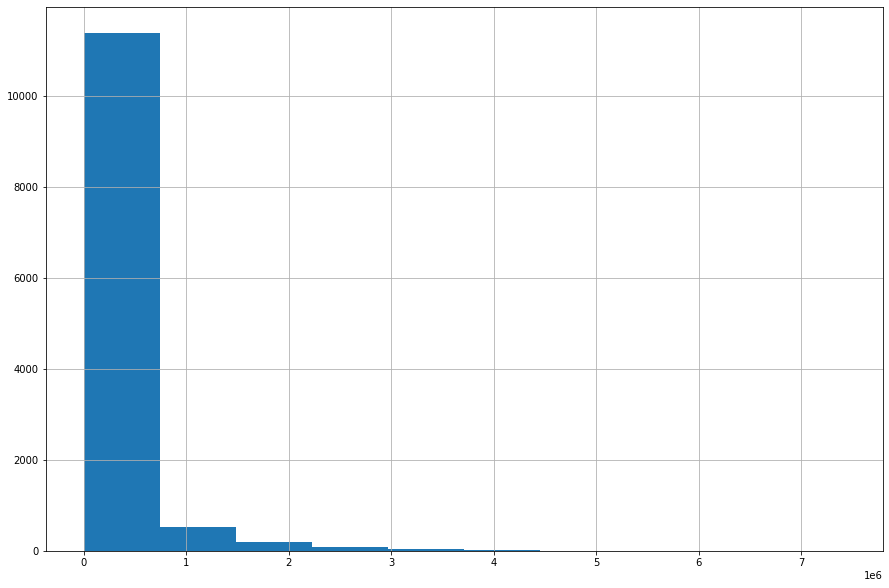

In [9]:
total_despesa_df.hist()

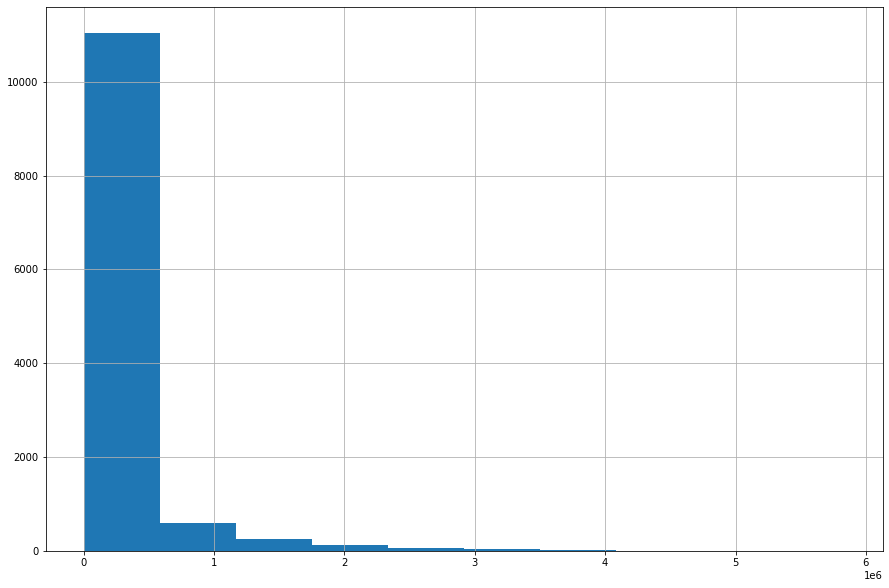

In [10]:
total_receita_df.hist()

Como podemos ver existem algumas váriaveis com viés. Podemos resolver isso por meio do uso de Log. Deixando os dados mais normalizados. Por exemplo: vamos visualizar a forma logaritmica dos dados da variável 'total_despesa'.

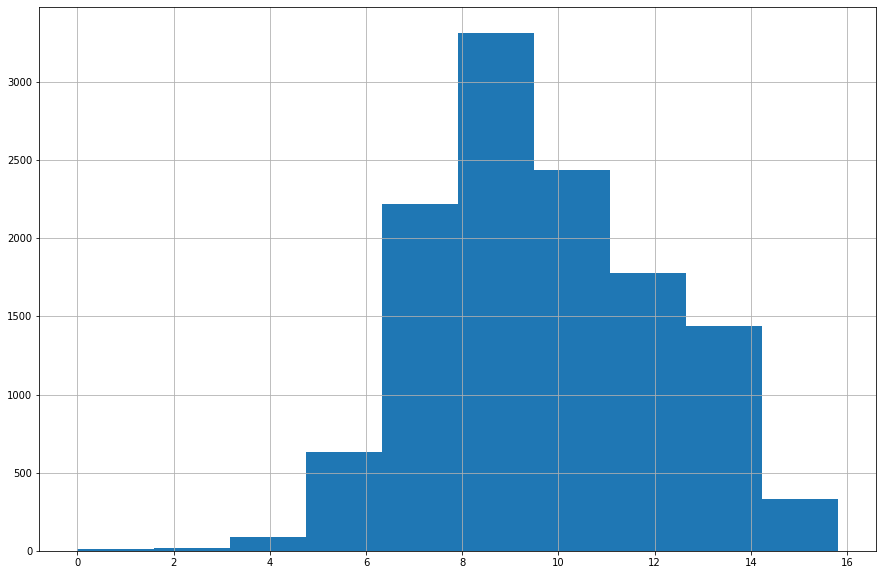

In [11]:
total_despesa_log_df = pd.DataFrame({"log_value":np.log1p(total_despesa_df)})

total_despesa_log_df['log_value'].hist()

Podemos ver que houve uma melhora no viés das informações. Desse modo, podemos aplicar o mesmo procedimento para as outras variáveis numéricas. Mas para isso precisamos definir uma tolerância no valor do desvio. 

Utilizando o exemplo do material de estudo disponibilizado no Kaggle, vamos utilizar como referência o valor de 0.75 como limiar para o viés.

In [12]:
number_column_filter = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[number_column_filter].apply(lambda x: x.dropna().skew())
skewed_feats

ano                                      -0.234904
sq_candidato                             -0.037113
qtd_doacoes                              44.008592
qtd_doadores                             42.113330
total_receita                             4.772896
media_receita                             9.543317
recursos de outros candidatos/comitês    12.280405
recursos de pessoas físicas               6.813025
recursos de pessoas jurídicas             3.681795
recursos próprios                        14.395394
qtd_despesas                              7.574750
qtd_fornecedores                          7.675399
total_despesa                             4.911894
media_despesa                            78.975047
votos                                     8.283525
dtype: float64

In [13]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats

qtd_doacoes                              44.008592
qtd_doadores                             42.113330
total_receita                             4.772896
media_receita                             9.543317
recursos de outros candidatos/comitês    12.280405
recursos de pessoas físicas               6.813025
recursos de pessoas jurídicas             3.681795
recursos próprios                        14.395394
qtd_despesas                              7.574750
qtd_fornecedores                          7.675399
total_despesa                             4.911894
media_despesa                            78.975047
votos                                     8.283525
dtype: float64

Agora que filtramos o viés nas variáveis, vamos agora aplicar o log nelas.

Valor antes do log:

In [14]:
df[number_column_filter].head()

,ano,sq_candidato,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,votos
0,2006,10001,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,8579
1,2006,10002,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,2757
2,2006,10002,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,17428
3,2006,10002,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,1193
4,2006,10003,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,29401


Valor após o log:

In [15]:
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])
df[number_column_filter].head()

,ano,sq_candidato,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,votos
0,2006,10001,1.945910,1.945910,9.717218,7.925760,NaN,9.105091,8.748464,7.170888,2.708050,2.708050,9.716230,7.077956,9.057189
1,2006,10002,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,3.178054,9.919705,6.785292,7.922261
2,2006,10002,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,4.691348,11.891449,7.210050,9.765891
3,2006,10002,1.945910,1.945910,8.007074,6.216979,NaN,7.048386,7.004991,6.621406,2.197225,2.197225,8.007074,5.929961,7.085064
4,2006,10003,3.891820,3.891820,NaN,NaN,NaN,10.837206,NaN,11.141035,4.897840,4.795791,11.664939,6.878469,10.288818


# Ajustando valores nulos ou NaN

Agora vamos ajustar os valores NaN no dataframe. Para isso vamos preencher esses valores ausentes com a média de valor de cada registro.

In [16]:
df = df.fillna(df.mean())
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,ano,sq_candidato,nome,uf,partido,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,...,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,cargo,sexo,grau_instrucao,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,1.945910,1.945910,9.717218,7.925760,8.370968,...,2.708050,2.708050,9.716230,7.077956,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,9.057189
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,2.639057,2.639057,10.035699,7.471276,8.798757,...,3.218876,3.178054,9.919705,6.785292,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,7.922261
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,2.890372,2.833213,11.905790,9.133303,7.719130,...,4.820282,4.691348,11.891449,7.210050,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,9.765891
3,2006,10002,ROMALDO MILANI,MS,PRONA,1.945910,1.945910,8.007074,6.216979,8.370968,...,2.197225,2.197225,8.007074,5.929961,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,7.085064
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,3.891820,3.891820,9.670482,7.468538,8.370968,...,4.897840,4.795791,11.664939,6.878469,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,10.288818


# Ajustando variáveis categóricas

Além de aplicar o log e tirar os valores NaN, precisamos organizar as variáveis categóricas, pois elas estão em forma de string. Nesse caso vamos utilizar uma função da biblioteca Pandas para transformar esse valores.

Os valores serão preenchidos com valores 0 e 1 quando o determinado valor não ocorre e ocorre respectivamente.

In [17]:
df = pd.get_dummies(df)
df.head()

,ano,sq_candidato,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,...,ocupacao_TÉCNICO DE QUÍMICA,ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,10001,1.945910,1.945910,9.717218,7.925760,8.370968,9.105091,8.748464,7.170888,...,0,0,0,0,0,0,1,0,0,0
1,2006,10002,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,0
2,2006,10002,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,0,0
3,2006,10002,1.945910,1.945910,8.007074,6.216979,8.370968,7.048386,7.004991,6.621406,...,0,0,0,0,0,0,0,0,0,0
4,2006,10003,3.891820,3.891820,9.670482,7.468538,8.370968,10.837206,10.021113,11.141035,...,0,0,0,0,0,0,0,0,0,0


# Dados de treino e teste

Antes de separarmos, vamos eliminar a coluna 'sequencial_candidato', pois ela representa apenas o id no dataset, acredito que não será relevante para o modelo essa informação

In [18]:
df = df.drop(['sq_candidato'], axis=1)

Vamos ver como o modelo se comporta apenas com os dados de 2006 e 2010 inicialmente. Depois de verificar o modelo com esses dados, vamos ao final utilizar os dados de 2014 para verificar a eficácia de cada modelo construído.

Inicialmente vamos aplicar a técnica Holdout para os dados de 2006 e 2010 juntos. Utilizaremos 80% para treino e 20% para teste. Os dados serão escolhidos aleatoriamente.

In [19]:
df_2006 = df[df.ano == 2006]
df_2010 = df[df.ano == 2010]

df_2006_2010_processado = df_2006.append(df_2010)

df_2006_2010_processado.head()

,ano,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,...,ocupacao_TÉCNICO DE QUÍMICA,ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,1.945910,1.945910,9.717218,7.925760,8.370968,9.105091,8.748464,7.170888,2.708050,...,0,0,0,0,0,0,1,0,0,0
1,2006,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,...,0,0,0,0,0,0,0,0,0,0
2,2006,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,2006,1.945910,1.945910,8.007074,6.216979,8.370968,7.048386,7.004991,6.621406,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,2006,3.891820,3.891820,9.670482,7.468538,8.370968,10.837206,10.021113,11.141035,4.897840,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_train, df_test = train_test_split(df_2006_2010_processado, test_size=0.2, random_state = 42)

x_train = df_train.drop('votos', axis=1)
y_train = df_train['votos']

x_test = df_test.drop('votos', axis=1)
y_test = df_test['votos']

x_geral = df_2006_2010_processado.drop('votos', axis=1)
y_geral = df_2006_2010_processado['votos']

# Criando modelo de Regressão Logística

Treinando o modelo

In [21]:
model_reg = LinearRegression()
model_reg.fit(x_train, y_train)

LinearRegression()

Realizando a predição dos dados

In [22]:
y_pred_reg = model_reg.predict(x_test)

## Valor do RMSE

In [23]:
calcular_rmse(y_test, y_pred_reg)

2803889792.358155

## Visualização dos resíduos e predições

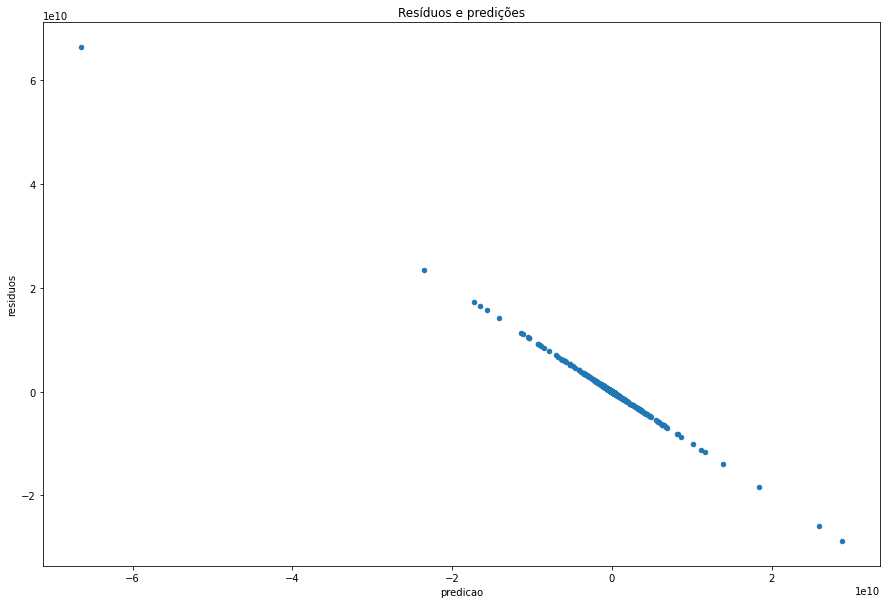

In [24]:
df_pred = plot_res_e_pred(y_pred_reg, y_test,"Resíduos e predições")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee5ac7ce50>,
      dtype=object)

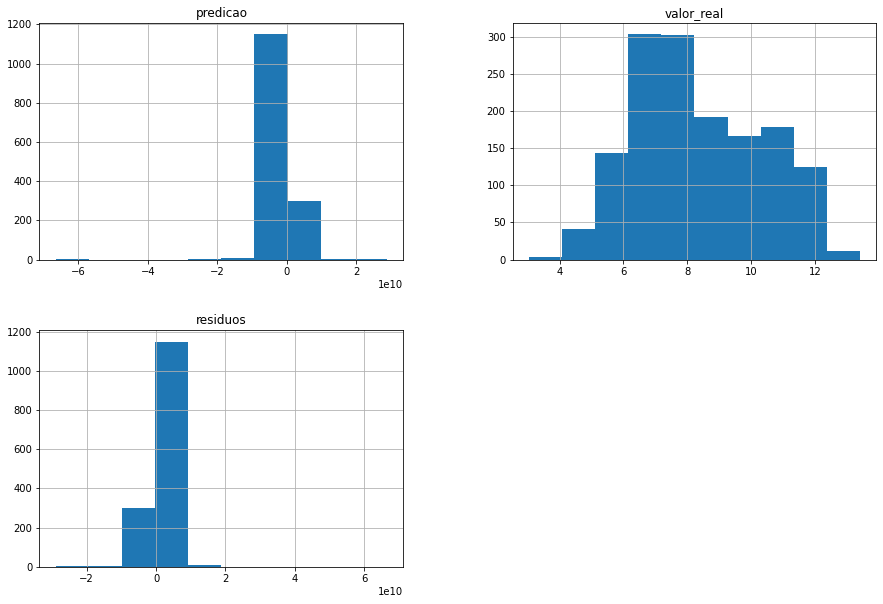

In [25]:
df_pred.hist()

Podemos notar que o modelo não se saiu bem. Vemos que as predições estão mais voltadas à direita e muito longe de se atingir o valor ideal para a maioria dos dados como mostra o grafico 'valor_real' que corresponde ao valor real do dado.

# Cross-validation e regularização

O modelo anterior não se saiu muito bem, ficando longe de ser um modelo ideal.
No modelo anterior, utilizamos o Holdout. Será que conseguimos melhorar o modelo utilizando regularização e Cross-validation? Vamos descobrir.

## Modelo RIDGE

Vamos utilizar o Ridge e o k-fold Cross-validation, com k= 5. Além disso, vamos escolher alguns valores de alfas para verificar como o modelo se comporta em relação a eles e em seguida verificar qual se saiu melhor.

In [26]:
cv = 5

In [27]:
alphas = [0.2, 0.3, 0.5, 1, 2, 5]
value_ridge_rmse = [calcular_rmse_cv(Ridge(alpha=alpha), x_geral, y_geral, cv).mean() for alpha in alphas]

value_ridge_rmse

Valor do RMSE: [0.92461405 0.93299425 0.96769538 0.98304067 0.90141548] 
Valor do RMSE: [0.92404823 0.93055739 0.96664067 0.9808032  0.89760317] 
Valor do RMSE: [0.92471454 0.92823288 0.96588345 0.97755327 0.89443327] 
Valor do RMSE: [0.92802046 0.92674453 0.96654494 0.97372586 0.89302128] 
Valor do RMSE: [0.9338471  0.92761342 0.96968921 0.97217207 0.89483051] 
Valor do RMSE: [0.94232384 0.93058888 0.97544234 0.9722805  0.89975922] 


[0.9419519654060874,
 0.939930533336973,
 0.9381634804258617,
 0.9376114160772614,
 0.9396304635991187,
 0.9440789559191838]

In [29]:
cv_ridge = pd.Series(value_ridge_rmse, index = alphas)
cv_ridge.mean()

0.9402278024607477

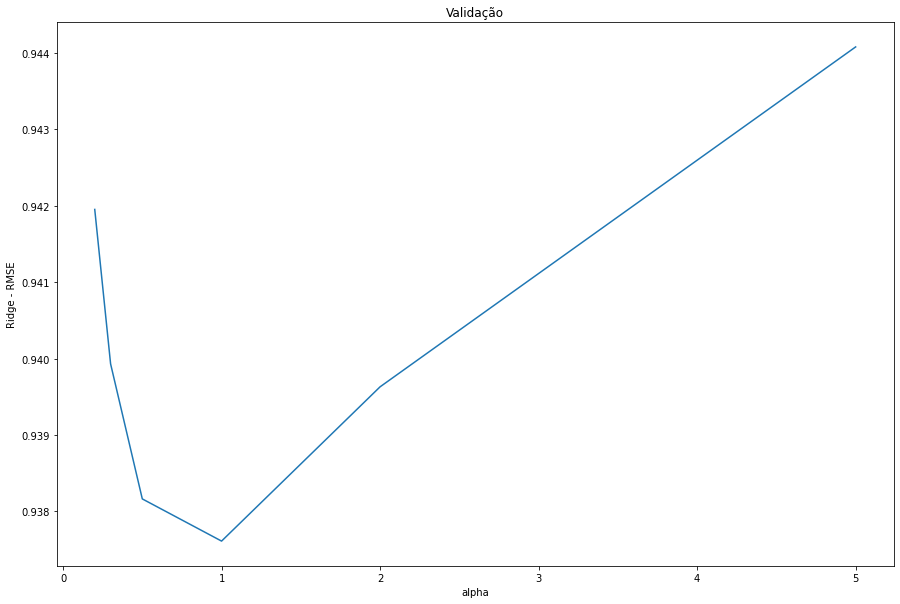

In [28]:
plot_validacao(value_ridge_rmse, alphas, "Ridge - RMSE")

Podemos ver que quando o valor de alpha é muito grande o modelo não consegue capturar toda a complexidade dos dados. Por outro lado, quando o alpha é pequeno demais o modelo começa a se ajustar demais podendo causar overfiting.

Nos resultados obtidos e com base no gráfico, dentre os valores de alpha, o valor alpha = 1 foi o que se saiu melhor.

## Criar o modelo Ridge com o melhor parâmetro

In [30]:
model_ridge = Ridge(alpha=1)

model_ridge.fit(x_train, y_train)

Ridge(alpha=1)

Vamos treinar esse modelo e depois testar nos dados de teste para ver se ele se sai melhor que o modelo anterior de regressão logística sem regularização

In [31]:
y_pred_ridge = model_ridge.predict(x_test)
rmse_ridge = calcular_rmse(y_test, y_pred_ridge)
rmse_ridge

0.9292733100553906

Podemos ver que obtivemos um valor bem melhor que o modelo anterior. Então podemos ver que o uso do Cross-validation nos ajudou a encontrar os melhores parâmetros para nosso modelo e em conjunto com a regularização melhorou bastante o resultado do nosso modelo.

Vamos visualizar a distribuição dos resíduos

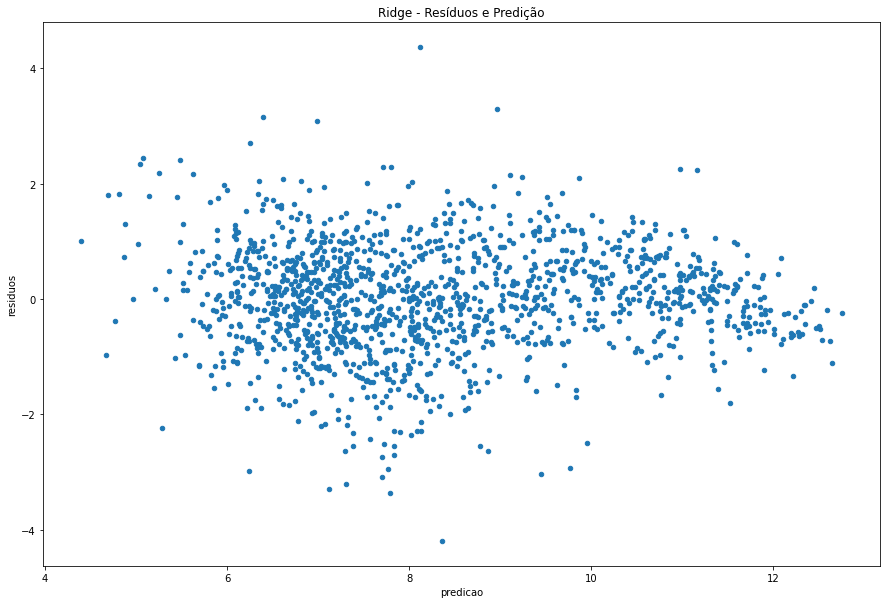

In [32]:
df_pred = plot_res_e_pred(y_pred_ridge, y_test, "Ridge - Resíduos e Predição")

Vemos uma grande melhora no resultado se comparado ao modelo anterior. O modelo anterior era praticamente uma "reta", aqui temos uma distribuição melhor.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee5999b290>,
      dtype=object)

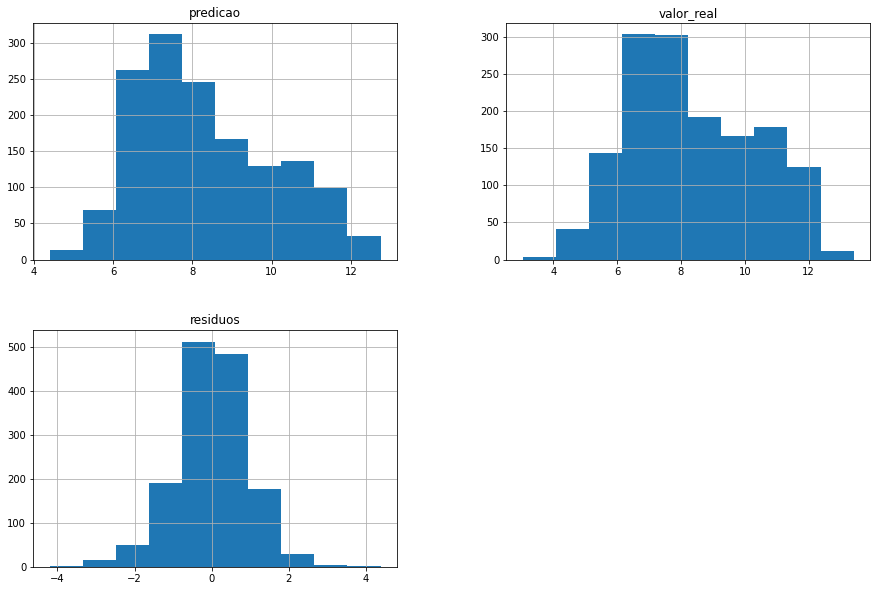

In [33]:
df_pred.hist()

Vemos também pelos gráficos acima que os valores preditos pelo modelo se assemelha ao valor real do dado, bem como sua distribuição. Ou seja, tivemos um resultado bem melhor que o modelo anterior.

## Modelo Lasso

Agora vamos verificar o Lasso. Realizando o procedimento semelhante ao que fizemos no modelo Ridge.

In [34]:
model_lasso = LassoCV(normalize=True, tol=1e-2, alphas = [1, 0.1, 0.001, 0.0005], max_iter=4000, n_jobs=-1, cv=cv)
model_lasso = model_lasso.fit(x_geral, y_geral)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [35]:
print(f"Melhor alpha para Lasso: {model_lasso.alpha_}")

Melhor alpha para Lasso: 0.0005


## Criar o modelo Lasso com o melhor alpha

In [36]:
model_lasso = Lasso(alpha=0.0005, tol=1e-2, max_iter=4000)
model_lasso.fit(x_train, y_train)

Lasso(alpha=0.0005, max_iter=4000, tol=0.01)

In [37]:
y_pred_lasso = model_lasso.predict(x_test)


In [38]:
rmse_lasso = calcular_rmse(y_test, y_pred_lasso)
rmse_lasso

0.9466751366786604

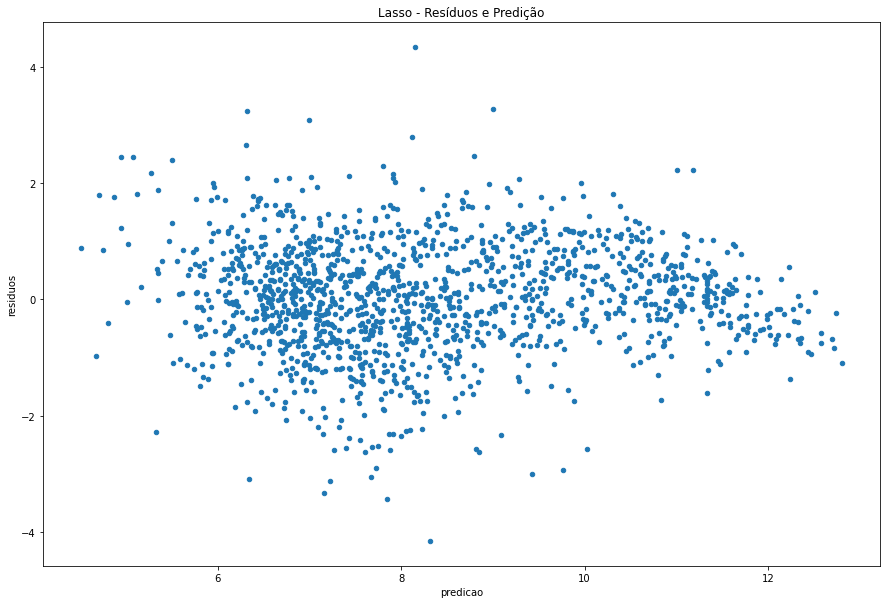

In [39]:
df_pred = plot_res_e_pred(y_pred_lasso, y_test, "Lasso - Resíduos e Predição")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee5ace4550>,
      dtype=object)

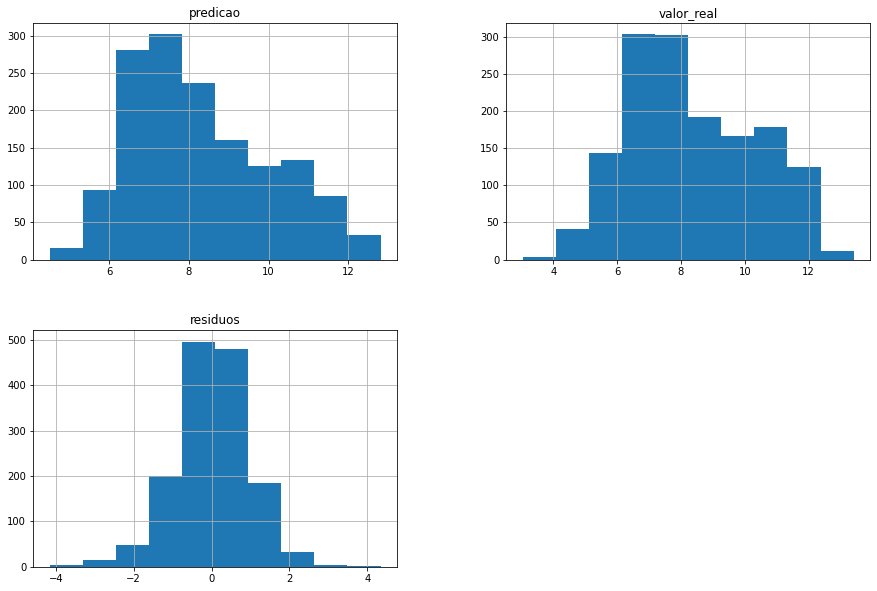

In [40]:
df_pred.hist()

Como podemos ver, tanto pelo RMSE como nos gráficos, o resultado entre o Lasso e o Ridge foram bem similares, porém o Ridge se saiu um pouco melhor.

Podemos ver também quantas variáveis o Lasso selecionou e quantas foram rejeitadas.

In [41]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print(f"Lasso selecionou {sum(coef != 0)} variáveis e rejeitou {sum(coef == 0)} variáveis")

Lasso selecionou 176 variáveis e rejeitou 11030 variáveis


Podemos dar uma olhada nos coeficientes

Text(0.5, 1.0, 'Coeficientes do modelo Lasso')

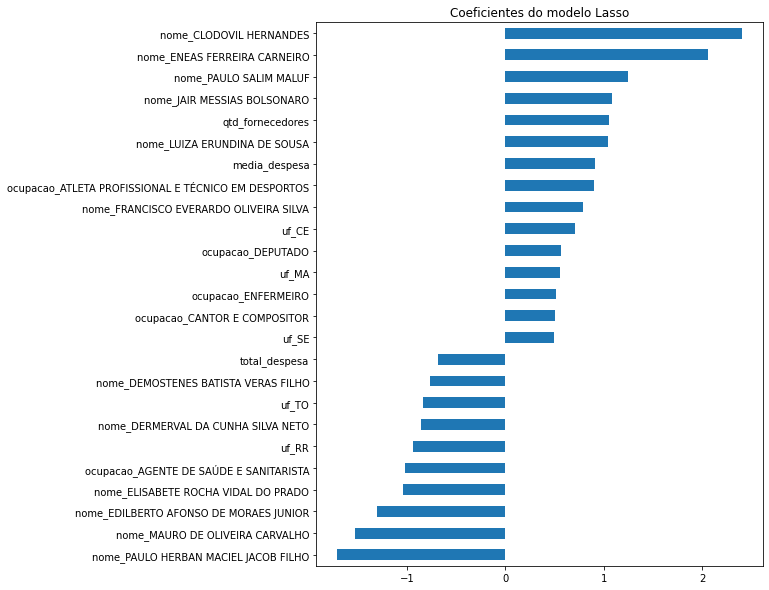

In [42]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef_df = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(15)])
coef_df.plot(kind= 'barh')
plt.title("Coeficientes do modelo Lasso")

Podemos ver pelo gráfico que o modelo selecionou como feature positiva mais importante 'nome_Clodovil Hernandes'. Além dos nomes, algumas outras features foram selecionadas como: qtd_fornecedores, algumas UFs. ocupações, etc.

## Utilizando outro modelo: KNN

Vamos utilizar outro modelo que não foi visto. Se trata do KNN.

In [43]:
model_knn = KNeighborsRegressor(n_neighbors=5).fit(x_train, y_train)

In [44]:
y_pred_knn = model_knn.predict(x_test)
y_pred_knn

array([ 9.95287467,  8.18898522,  8.41444002, ..., 11.46751165,
        9.42864174,  9.57350262])

In [45]:
mse_knn = calcular_rmse(y_test, y_pred_knn)
mse_knn

1.009874759890714

Vamos visualizar os resíduos

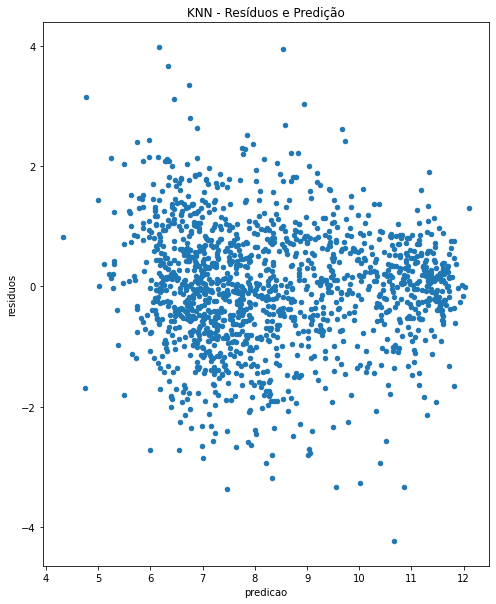

In [46]:
df_pred = plot_res_e_pred(y_pred_knn, y_test, "KNN - Resíduos e Predição")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee57d03410>,
      dtype=object)

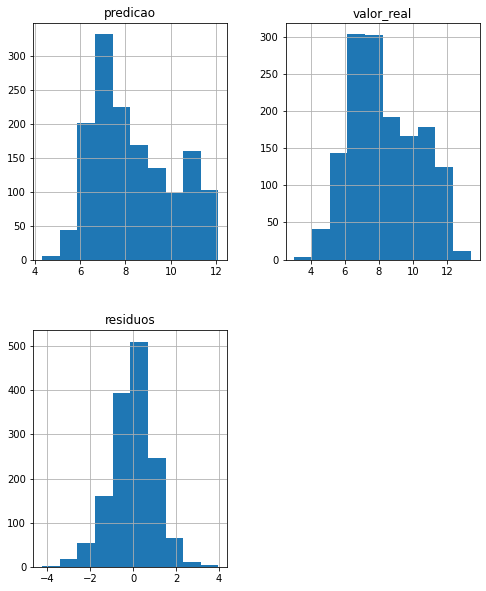

In [47]:
df_pred.hist()

O resultado ficou próximo dos modelos Ridge e Lasso, porém o modelo KNN apresentou um desempenho um pouco inferior se comparado aos dois modelos(Ridge e Lasso), mas se saiu bem melhor que o modelo inicial de regressão sem regularização.

# Visualizando todos os modelos juntos

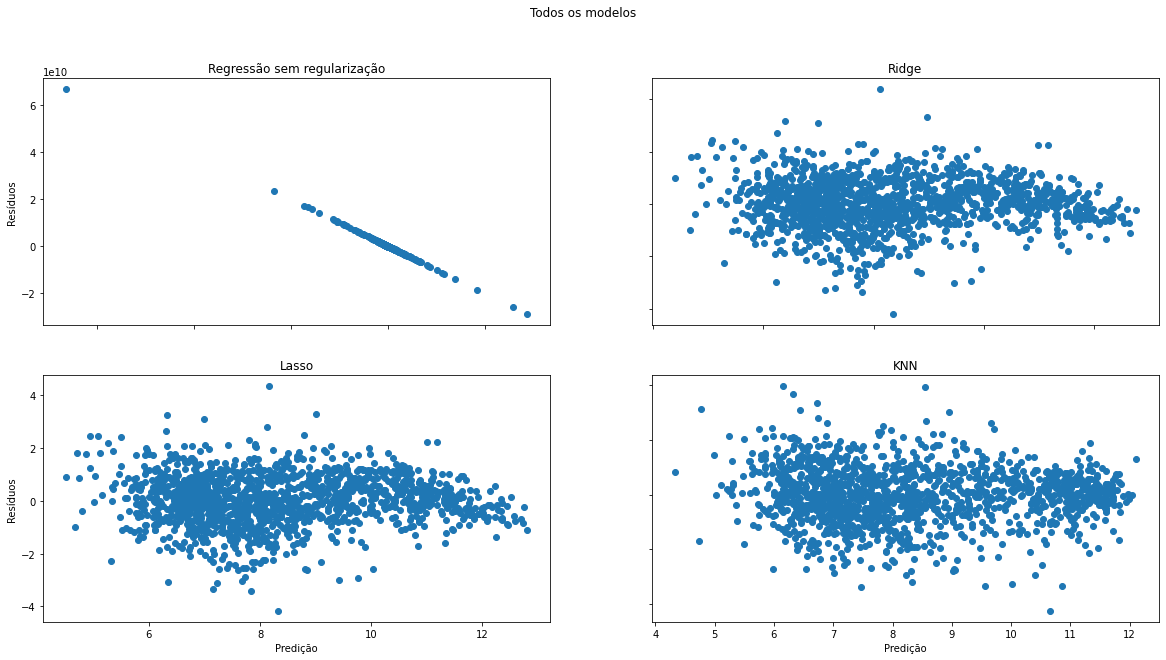

In [48]:
matplotlib.rcParams['figure.figsize'] = (20, 10.0)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Todos os modelos')

df_pred = get_df_plot(y_pred_reg, y_test)
df_pred_ridge = get_df_plot(y_pred_ridge, y_test)
df_pred_lasso = get_df_plot(y_pred_lasso, y_test)
df_pred_knn = get_df_plot(y_pred_knn, y_test)

X_axis = "predicao"
Y_axis = "residuos"
kind_plot = "scatter"

axs[0, 0].scatter(df_pred[X_axis], df_pred[Y_axis])
axs[0, 0].set_title('Regressão sem regularização')
axs[0, 1].scatter(x = df_pred_ridge[X_axis], y = df_pred_ridge[Y_axis])
axs[0, 1].set_title('Ridge')
axs[1, 0].scatter(x = df_pred_lasso[X_axis], y = df_pred_lasso[Y_axis])
axs[1, 0].set_title('Lasso')
axs[1, 1].scatter(x = df_pred_knn[X_axis], y = df_pred_knn[Y_axis])
axs[1, 1].set_title('KNN')


for ax in axs.flat:
    ax.set(xlabel='Predição', ylabel='Resíduos')

for ax in axs.flat:
    ax.label_outer()

De forma geral, podemos ver com base nos valores de RMSE apresentados anteriormente, bem como nos gráficos, que dentre os modelos, o Ridge foi o melhor, seguido do Lasso, KNN e Regressão sem regularização.

# Verificando com os dados de 2014

Agora que temos os melhores modelos para os dados de 2006 e 2010, vamos agora utilizar os modelos para fazer a predição nos dados de 2014.

In [49]:
df_2014_processado = df[df.ano == 2014]
df_2014_processado.head()

,ano,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,...,ocupacao_TÉCNICO DE QUÍMICA,ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
7330,2014,1.386294,1.386294,7.365813,6.268465,8.370968,7.313887,10.021113,8.458250,1.386294,...,0,0,0,0,0,0,0,0,0,0
7331,2014,1.791759,1.791759,8.064951,6.456770,8.370968,8.039480,10.021113,8.458250,1.945910,...,0,0,0,0,0,0,0,0,1,0
7332,2014,3.713572,3.663562,12.716781,9.079305,7.562198,11.092869,11.945818,11.652696,4.983607,...,0,0,0,0,0,0,0,0,0,0
7333,2014,3.401197,3.401197,11.962218,8.595101,10.574474,11.138739,9.741027,8.826758,4.919981,...,0,0,0,0,0,0,0,0,0,0
7334,2014,5.081404,4.990433,13.474546,8.491143,9.210440,12.757293,12.531776,11.264477,6.251904,...,0,0,0,0,0,0,0,0,0,0


Agora vamos verificar nos nossos modelos já criados

In [50]:
x_2014 = df_2014_processado.drop('votos', axis=1)
y_2014 = df_2014_processado['votos']

y_pred_reg_2014 = model_reg.predict(x_2014)
y_pred_ridge_2014 = model_ridge.predict(x_2014)
y_pred_lasso_2014 = model_lasso.predict(x_2014)
y_pred_knn_2014 = model_knn.predict(x_2014)


In [51]:
reg_rmse_2014 = calcular_rmse(y_2014,y_pred_reg_2014)
ridge_rmse_2014 = calcular_rmse(y_2014,y_pred_ridge_2014)
lasso_rmse_2014 = calcular_rmse(y_2014,y_pred_lasso_2014)
knn_rmse_2014 = calcular_rmse(y_2014,y_pred_knn_2014)

print(f"RMSE Regressão Logística: {reg_rmse_2014}")
print(f"RMSE Ridge: {ridge_rmse_2014}")
print(f"RMSE Lasso: {lasso_rmse_2014}")
print(f"RMSE KNN: {knn_rmse_2014}")

RMSE Regressão Logística: 2745020265.2847977
RMSE Ridge: 1.6807497897450316
RMSE Lasso: 1.686876301549097
RMSE KNN: 1.7899914946217574


Podemos ver que os melhores modelos, do melhor para o pior, foram: Ridge, Lasso, KNN e Regressão.

Sendo que dentre eles os modelos Ridge e Lasso ficaram bem próximos.